**Table of contents**<a id='toc0_'></a>    
- [Cleaned Analysis of June 13th 2022 Flight at 100 Hz](#toc1_)    
  - [Purpose:](#toc1_1_)    
  - [Methods:](#toc1_2_)    
  - [Results:](#toc1_3_)    
  - [Naming and Folders](#toc1_4_)    
  - [Importing Packages and Libraries](#toc1_5_)    
  - [Importing data](#toc1_6_)    
  - [Defining Vehicle Parameters](#toc1_7_)    
  - [Manually Selecting Mask by Plots](#toc1_8_)    
    - [Results of the Manual Segmentation](#toc1_8_1_)    
    - [Checking Segments for Good Data](#toc1_8_2_)    
  - [Main Analysis: Getting $P_{req}$, $C_L$, $C_D$](#toc1_9_)    
    - [Methods:](#toc1_9_1_)    
    - [Notes for Potential Energy](#toc1_9_2_)    
    - [Observations from Above Plot:](#toc1_9_3_)    
    - [Collecting Averages and Standard Deviations from Segments](#toc1_9_4_)    
    - [Collecting Total Datapoints from each of the Segments](#toc1_9_5_)    
  - [Collecting Data into Bins](#toc1_10_)    
  - [Plotting Results of Bin and Segments](#toc1_11_)    
  - [Performing Curve Fits to Find Polars](#toc1_12_)    
  - [Packaging the Results](#toc1_13_)    
  - [Saving Results to Disk](#toc1_14_)    
  - [Additional Plots for Power Required](#toc1_15_)    
      - [Notes on Data Results](#toc1_15_1_1_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# <a id='toc1_'></a>[Cleaned Analysis of June 13th 2022 Flight at 100 Hz](#toc0_)

## <a id='toc1_1_'></a>[Purpose:](#toc0_)
* Use updated function to reduce the data just as previous analysis
* Store the results for comparisons

## <a id='toc1_2_'></a>[Methods:](#toc0_)

Only cruising methods can be applied to this dataset, CL is calculated only from airspeed and bank angle

## <a id='toc1_3_'></a>[Results:](#toc0_)
Appear to be different from the June 15th 2022 results, believe it has to do with the fact that the sun rose and thermal activity at low airpseeds

## <a id='toc1_4_'></a>[Naming and Folders](#toc0_)

In [38]:
### Definining name of analysis ###
name = '2022-06-13_CREATeV_Cruise_2022-04-30_Analysis_Cleaned'
data_path = '../../data/'
data_folder = 'createv-2022-06-13'
file_name = 'june13_2022.BIN'

datasave_path = data_path+data_folder+'/'
result_path = '../Results/'+name+'/'
figure_path = '../Figures/'+name+'/'

## <a id='toc1_5_'></a>[Importing Packages and Libraries](#toc0_)

In [39]:
from os import sys
import os
sys.path.append('../../')

%matplotlib widget

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

import main
from main import flight
from main import analysis
import propellers
import motors
from aircraft import airplane
import cl_finders

## Creating Folders for Results/Data ###
if not os.path.exists(result_path):
    os.makedirs(result_path)
if not os.path.exists(figure_path):
    os.makedirs(figure_path)
if not os.path.exists(data_path+data_folder):
    os.makedirs(data_path+data_folder)

# Setting Plot Defaults
plt.style.use('../../basic_plotter.mplstyle')

## <a id='toc1_6_'></a>[Importing data](#toc0_)

In [40]:
# Importing data, specifying import characteristics, backing up results
rate = "10ms"
interpolateM = "linear"
processor = "CREATeV_2022"

rawdata_name = data_folder+'/'+file_name.split('.')[0]+'_'+rate+'_'+interpolateM+'_'+processor+'.pkl'

# Checking if the data is already pickled for analysis
if os.path.exists(data_path+rawdata_name):
    df = pd.read_pickle(data_path+rawdata_name)
else:
    df = main.get_data(processor, data_path+data_folder+'/'+file_name, rate)
    df = df.interpolate(method=interpolateM)
    pd.to_pickle(df, data_path+rawdata_name) # Storing parsed data

## <a id='toc1_7_'></a>[Defining Vehicle Parameters](#toc0_)

In [41]:
# Vehicle parameters
prop = propellers.aeronaut20x8() # Using aeronaut 20x8 for this flight
motor = motors.U7V2_280KV()  # Using U7 V2 motor

mass = 12.727
span = 6.28
chord = 0.395
createv = airplane(mass, chord, span)

## <a id='toc1_8_'></a>[Manually Selecting Mask by Plots](#toc0_)

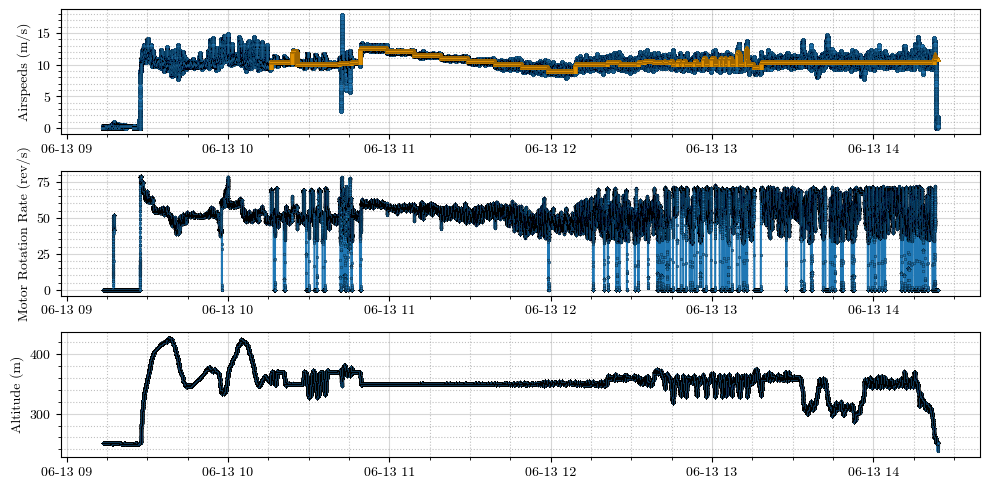

Plot already exists


In [42]:
# Plotting Airspeed for Establishing Cruising Time Intervals
timeindex_v_rpm_h = plt.figure(figsize=(10,5), dpi=100)
ax1 = plt.subplot(3,1,1)
ax1.plot(df.index, df.Airspeed_Sensor0, label="Airspeed", marker='o', markeredgecolor=[0,0,0], markersize=3, markeredgewidth=0.1)
ax1.plot(df.index, df.Airspeed_Demanded, label="Demanded Airspeed", color='orange', marker='^', markeredgecolor=[0,0,0], markersize=3, markeredgewidth=0.05)
ax1.set_ylabel("Airspeeds (m/s)")
ax1.grid(which='major', linestyle='-')
ax1.grid(which='minor', linestyle=':', color='grey')
#plt.legend()

ax2 = plt.subplot(3,1,2, sharex=ax1)
ax2.plot(df.index, df.MotorRPM/60, label='ESC Measurement')
ax2.set_ylabel("Motor Rotation Rate (rev/s)")
ax2.grid(which='major', linestyle='-')
ax2.grid(which='minor', linestyle=':', color='grey')
#plt.legend()

ax3 = plt.subplot(3,1,3, sharex=ax1)
ax3.plot(df.index, df.Altitude_POS, label='Altitude')
ax3.set_ylabel("Altitude (m)")
ax3.grid(which='major', linestyle='-')
ax3.grid(which='minor', linestyle=':', color='grey')
#plt.legend()

plt.show()
main.save_figure(timeindex_v_rpm_h, f'{timeindex_v_rpm_h=}'.split('=')[0], figure_path)

### <a id='toc1_8_1_'></a>[Results of the Manual Segmentation](#toc0_)

In [43]:
# Cruise Masking

seg_times = np.array([['10:49:30','10:59:07'],
                      ['10:59:12','11:09:07'],
                      ['11:09:12','11:19:08'],
                      ['11:19:12','11:29:08'],
                      ['11:29:12','11:39:08'],
                      ['11:39:12','11:49:08'],
                      ['11:49:12','11:59:08'],
                      ['11:59:12','12:09:08']])

year = 2022
month = 6
day = 13

masks = cl_finders.get_maskarray(df, seg_times, year, month, day)

### <a id='toc1_8_2_'></a>[Checking Segments for Good Data](#toc0_)

Looking through the altitude, and flight path to see if they are good enough for the method.  IE constant altitude, and a loiter that is circular.  

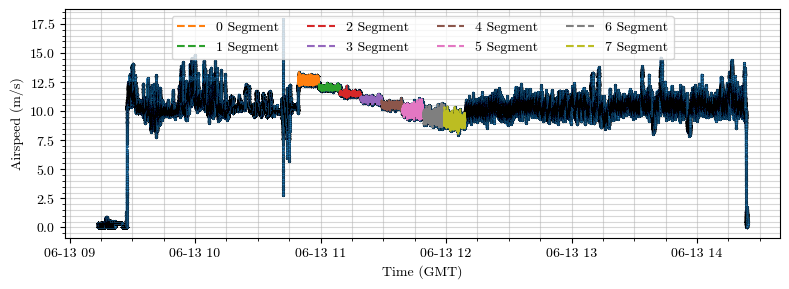

Plot already exists


In [44]:
# Airspeed for Segments
timeindex_v_segmented = plt.figure(figsize=(8,3), dpi=100)
plt.plot(df.index, df.Airspeed_Sensor0)
for i in np.arange(len(masks)):
    plt.plot(df.Airspeed_Sensor0[masks[i]], marker='', linestyle='--', label=str(i) + " Segment")
plt.ylabel("Airspeed (m/s)")
plt.xlabel("Time (GMT)")
plt.legend(loc='upper center',
          ncol=4, fancybox=True)
plt.tight_layout()
plt.show()
main.save_figure(timeindex_v_segmented, f'{timeindex_v_segmented=}'.split('=')[0], figure_path)

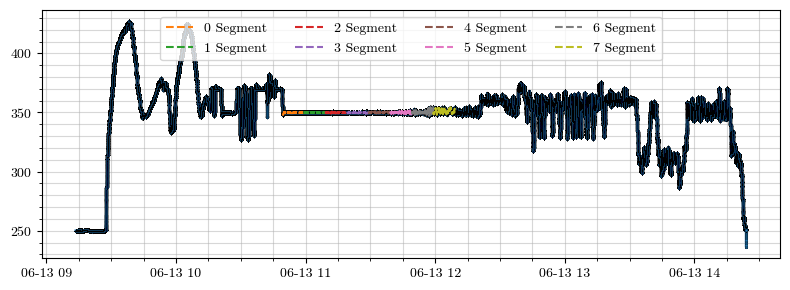

Plot already exists


In [45]:
# Altitude for Segments
timeindex_h_segmented = plt.figure(figsize=(8,3), dpi=100)
plt.plot(df.index, df.Altitude_POS)
for i in np.arange(len(masks)):
    plt.plot(df.Altitude_POS[masks[i]], marker='', linestyle='--', label=str(i) + " Segment")
plt.legend(loc='upper center',
          ncol=4, fancybox=True)
plt.tight_layout()
plt.show()
main.save_figure(timeindex_h_segmented, f'{timeindex_h_segmented=}'.split('=')[0], figure_path)

Notes on the selected intervals

* Interval 0 has airspeed discontinuities that are being ignored.  There seem to be few enough discontinuities to make the averaging method valid.  Would be a problem for any of the acceleration methods.  
* Latter intervals including segments 5, 6, 7 all have issues maintaining altitude.  Perhaps adding a potential energy term would improve the results?

## <a id='toc1_9_'></a>[Main Analysis: Getting $P_{req}$, $C_L$, $C_D$](#toc0_)

### <a id='toc1_9_1_'></a>[Methods:](#toc0_)
1. Cruise Efficiency Method
2. Thrust Method
3. Thrust Method, with potential energy term

In [46]:
############# Main Analysis ###############3
# Attitude 
phi = np.deg2rad(df["RollAngle"].to_numpy())            # Bank angle in radians

# Atmospheric adjustments:
rho = df["Pressure"].to_numpy() * (287 * (df["Ambient_Temperature"].to_numpy()+273.15))**-1             # Density found from barometer pressure & airspeed sensor temperatures
v_eas = df["Airspeed_Sensor0"].to_numpy()                               # Equivalent SSL airspeed (m/s)
v_tas = v_eas * np.sqrt(1.225) * np.sqrt(rho)**-1   # the true airspeed
q = 0.5 * rho * v_tas**2                            # Dynamic pressure 

# For Descent method
h = df["Altitude_POS"].to_numpy()                   # Altitude
Vd_eas = df["DescendingXK"].to_numpy()                  # Descent Rate from EKF (is it true or EAS at SSL?)
Vd_tas = Vd_eas * np.sqrt(1.225) * np.sqrt(rho)**-1   # the true airspeed

# Ground speed limiter
v_dem = df["Airspeed_Demanded"].to_numpy()

# Propulsion characterization
n = df["MotorRPM"].to_numpy() / 60                               # Revolutions per second
i_esc = df["EscCurrent"].to_numpy()
v_esc = df["EscVoltage"].to_numpy()
J = v_tas / (n * prop.diameter)
eff = prop.efficiency(J) * motor.efficiency(n, i_esc)

# Estimated propulsive power (New Fitting)
P_eta = cl_finders.eta_steady(prop, motor, v_tas, n, i_esc, v_esc)
P_ct = cl_finders.thrust_steady(prop, rho, v_tas, n)
P_pot = (createv.weight * Vd_tas)
P_ct_h = P_ct + P_pot

# Getting drag coefficient
Cd_eta = cl_finders.preq2cd(createv, v_tas, q, P_eta)
Cd_ct = cl_finders.preq2cd(createv, v_tas, q, P_ct)
Cd_ct_h = cl_finders.preq2cd(createv, v_tas, q, P_ct_h)

# Getting lift coefficient
CL = cl_finders.cl_banked(createv, q, phi)

/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_95112/581253678.py:6: RuntimeWarning: invalid value encountered in reciprocal
  rho = df["Pressure"].to_numpy() * (287 * (df["Ambient_Temperature"].to_numpy()+273.15))**-1             # Density found from barometer pressure & airspeed sensor temperatures
/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_95112/581253678.py:8: RuntimeWarning: invalid value encountered in reciprocal
  v_tas = v_eas * np.sqrt(1.225) * np.sqrt(rho)**-1   # the true airspeed
/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_95112/581253678.py:14: RuntimeWarning: invalid value encountered in reciprocal
  Vd_tas = Vd_eas * np.sqrt(1.225) * np.sqrt(rho)**-1   # the true airspeed
/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_95112/581253678.py:23: RuntimeWarning: divide by zero encountered in true_divide
  J = v_tas / (n * prop.diameter)
/var/folders/x_/hvhbycx15x31bybxtb1h9ktc0000gn/T/ipykernel_95112/581253678.py:23: Runti

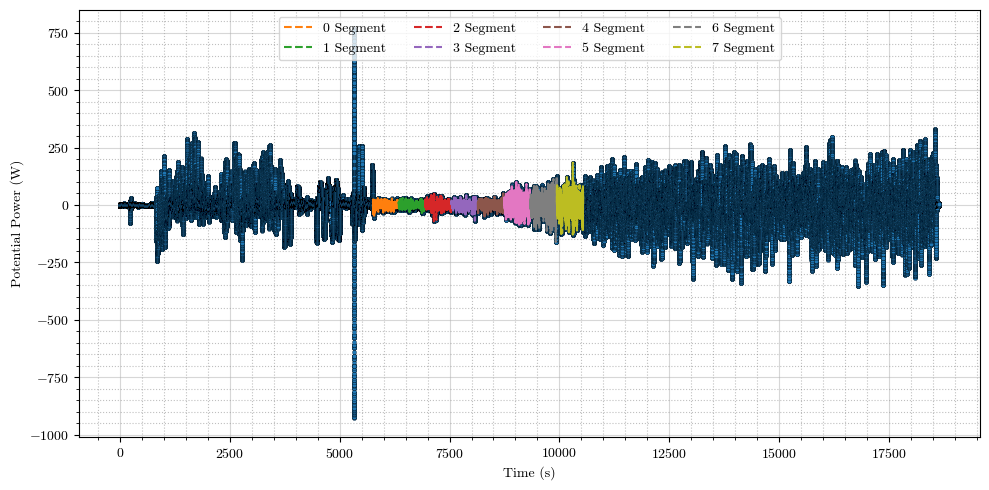

In [47]:
# Getting Visual of Descending Powers #
plt.figure(figsize=(10,5))
t_init = 0
time_s = np.linspace(t_init, (len(v_tas)-1)/100 + t_init, len(v_tas))

plt.plot(time_s, P_pot, linestyle='', marker='o', markersize=3)
for i in np.arange(len(masks)):
    plt.plot(time_s[masks[i]], P_pot[masks[i]], marker='', linestyle='--', label=str(i) + " Segment")
plt.xlabel("Time (s)")
plt.ylabel("Potential Power (W)")
plt.legend(loc='upper center', ncol=4, fancybox=True)
plt.grid(which='major', linestyle='-')
plt.grid(which='minor', linestyle=':', color='grey')
plt.minorticks_on()
plt.show()

### <a id='toc1_9_2_'></a>[Notes for Potential Energy](#toc0_)

Last two segments are noisy with contributions from the change in altitude due to the atmospheric disturbances of thermals.  

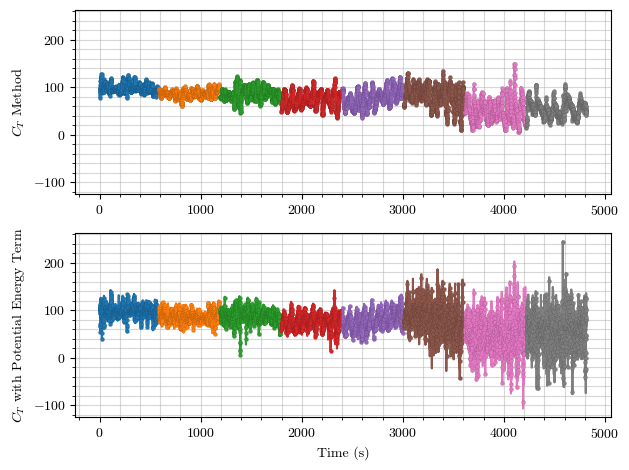

In [48]:
# Comparing CT vs CT with Altitude Alteration

markerstyle = 'o'
markerevery = 80
markedgew = 0.05

plt.figure()

ax0 = plt.subplot(2,1,1)
ax1 = plt.subplot(2,1,2, sharex=ax0, sharey=ax0)

for i in range(len(masks)):
    time_s = np.linspace(t_init, (len(v_tas[masks[i]])-1)/100 + t_init, len(v_tas[masks[i]]))
    ax0.plot(time_s, P_ct[masks[i]], marker=markerstyle, markevery=markerevery, markeredgecolor=[0,0,0], markersize=3, markeredgewidth=markedgew)
    ax1.plot(time_s, P_ct_h[masks[i]], marker=markerstyle, markevery=markerevery, markeredgecolor=[0,0,0], markersize=3, markeredgewidth=markedgew)
    t_init = time_s[-1]+10
ax0.set_ylabel("$C_T$ Method")
ax1.set_ylabel("$C_T$ with Potential Energy Term")
ax1.set_xlabel("Time (s)")
plt.show()

### <a id='toc1_9_3_'></a>[Observations from Above Plot:](#toc0_)

Substantial noise has been added to the power required measurement with the potential energy term,  doesn't appear to help with the hump in power required between the 5 and 6 segments.  What could this becoming from?  Possibly just a massive thermal that drastically affected the throttle for a long time (4-5 minutes).  Potential energy compensation only works when there is not airmass motion.  

### <a id='toc1_9_4_'></a>[Collecting Averages and Standard Deviations from Segments](#toc0_)
Going through the averages and standard deviations and 95% confidence intervals of each segment.  

In [49]:
[cl_means_eta, cl_stds_eta, cl_ci95s_eta, cd_means_eta, cd_stds_eta, cd_ci95s_eta] = cl_finders.collect_segments(masks, CL, Cd_eta)
[cl_means_ct, cl_stds_ct, cl_ci95s_ct, cd_means_ct, cd_stds_ct, cd_ci95s_ct] = cl_finders.collect_segments(masks, CL, Cd_ct)
[cl_means_cth, cl_stds_cth, cl_ci95s_cth, cd_means_cth, cd_stds_cth, cd_ci95s_cth] = cl_finders.collect_segments(masks, CL, Cd_ct_h)

### <a id='toc1_9_5_'></a>[Collecting Total Datapoints from each of the Segments](#toc0_)
Not averaging or processing, just raw CL, CD datapoints collected for display.  

In [50]:
# Totalling up CL, CD for Cruise
cl_total_cruise = cl_finders.total_segments_boolean(CL, masks)
cd_total_eta = cl_finders.total_segments_boolean(Cd_eta, masks)
cd_total_ct = cl_finders.total_segments_boolean(Cd_ct, masks)
cd_total_cth = cl_finders.total_segments_boolean(Cd_ct_h, masks)

## <a id='toc1_10_'></a>[Collecting Data into Bins](#toc0_)
Using bins for collection of the drag polar points.  

In [51]:
bins = np.linspace(0.05, 1.1, 51)
[cl_means_eta_bin, cl_stds_eta_bin, cl_ci95s_eta_bin, cd_means_eta_bin, cd_stds_eta_bin, cd_ci95s_eta_bin] = cl_finders.collect_bins(bins, cl_total_cruise, cd_total_eta)
[cl_means_ct_bin, cl_stds_ct_bin, cl_ci95s_ct_bin, cd_means_ct_bin, cd_stds_ct_bin, cd_ci95s_ct_bin] = cl_finders.collect_bins(bins, cl_total_cruise, cd_total_ct)
[cl_means_cth_bin, cl_stds_cth_bin, cl_ci95s_cth_bin, cd_means_cth_bin, cd_stds_cth_bin, cd_ci95s_cth_bin] = cl_finders.collect_bins(bins, cl_total_cruise, cd_total_cth)

/Users/williamkemp/Records/Repositories/CREATeV_AnalysisSuite/Investigations/21_Cleaned_Performance_Analysis/../../cl_finders.py:401: RuntimeWarning: Mean of empty slice.
  cl_means = [total_lift_coeffs[digitized == i].mean() for i in range(1, len(bins))]
/Users/williamkemp/opt/anaconda3/envs/superwake-records/lib/python3.10/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/williamkemp/opt/anaconda3/envs/superwake-records/lib/python3.10/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/williamkemp/opt/anaconda3/envs/superwake-records/lib/python3.10/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/williamkemp/opt/anaconda3/envs/superwake-records/lib/python3.1

## <a id='toc1_11_'></a>[Plotting Results of Bin and Segments](#toc0_)

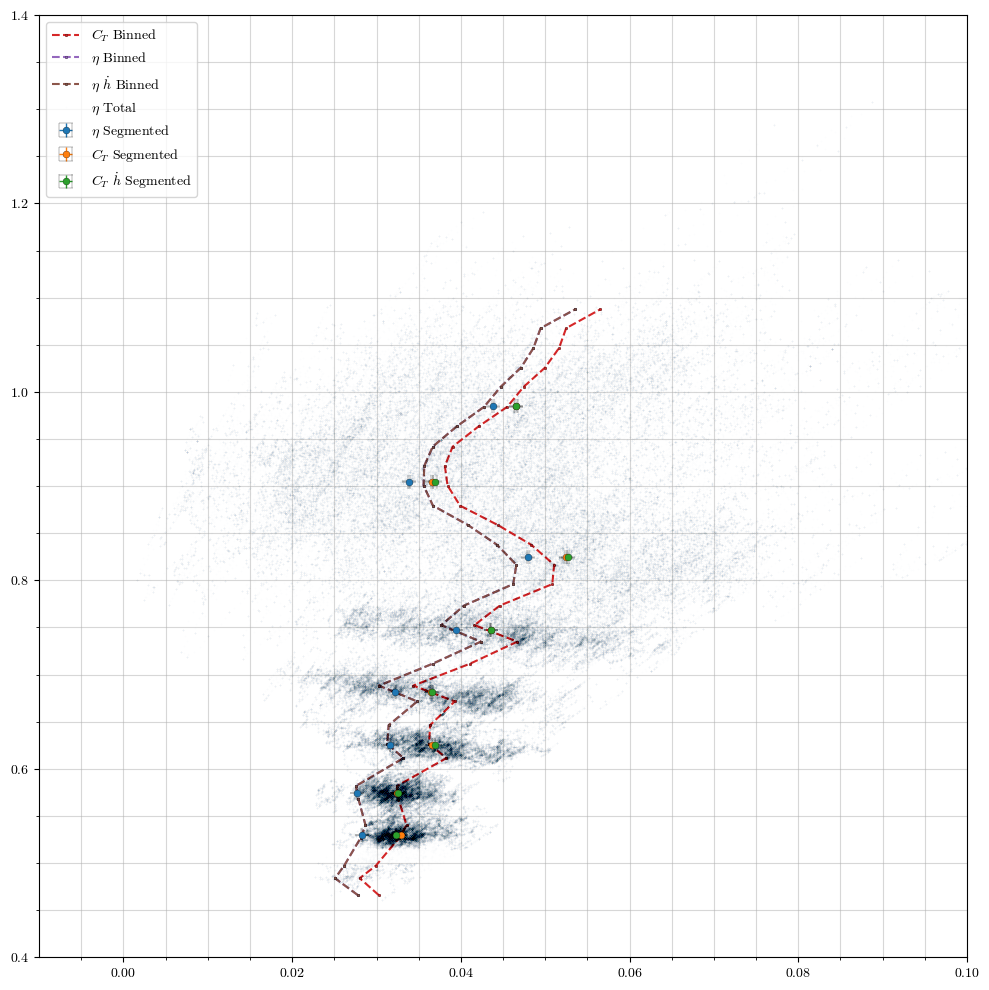

Plot already exists


In [52]:
CruisePolar_RawANDsegmented = plt.figure(figsize=(10,10), dpi=100)
plt.errorbar(cd_means_eta, cl_means_eta, xerr=cd_ci95s_eta, yerr=cl_ci95s_eta, linestyle='', markersize = 10, capsize=5, elinewidth=1, label="$\eta$ Segmented")
plt.errorbar(cd_means_ct, cl_means_ct, xerr=cd_ci95s_ct, yerr=cl_ci95s_ct, linestyle='', markersize = 10, capsize=5, elinewidth=1, label="$C_T$ Segmented")
plt.errorbar(cd_means_cth, cl_means_cth, xerr=cd_ci95s_cth, yerr=cl_ci95s_cth, linestyle='', markersize = 10, capsize=5, elinewidth=1, label="$C_T$ $\dot{h}$ Segmented")
plt.plot(cd_means_ct_bin, cl_means_ct_bin, linestyle='--', label="$C_T$ Binned")
plt.plot(cd_means_eta_bin, cl_means_eta_bin, linestyle='--', label="$\eta$ Binned")
plt.plot(cd_means_cth_bin, cl_means_cth_bin, linestyle='--', label="$\eta$ $\dot{h}$ Binned")


plt.plot(cd_total_ct, cl_total_cruise, linestyle='', color="C{}".format(0), alpha=0.01, marker='.', markersize=2, label="$\eta$ Total")
plt.xlim([-0.01, 0.1])
plt.ylim([0.4, 1.4])
plt.legend()
plt.show()
main.save_figure(CruisePolar_RawANDsegmented, f'{CruisePolar_RawANDsegmented=}'.split('=')[0], figure_path)

## <a id='toc1_12_'></a>[Performing Curve Fits to Find Polars](#toc0_)

In [53]:
polar_eta = cl_finders.cd2polar(createv, cd_means_eta, cl_means_eta, highorder=False)
polar_ct = cl_finders.cd2polar(createv, cd_means_ct, cl_means_ct, highorder=False)
polar_cth = cl_finders.cd2polar(createv, cd_means_cth, cl_means_cth, highorder=False)

polar_eta_bin = cl_finders.cd2polar(createv, cd_means_eta_bin, cl_means_eta_bin, highorder=False)
polar_ct_bin = cl_finders.cd2polar(createv, cd_means_ct_bin, cl_means_ct_bin, highorder=False)
polar_cth_bin = cl_finders.cd2polar(createv, cd_means_cth_bin, cl_means_cth_bin, highorder=False)

print(polar_eta)
print(polar_ct)
print(polar_cth)

print(polar_eta_bin)
print(polar_ct_bin)
print(polar_cth_bin)

[0.02315107 0.90389884]
[0.0290481 1.0583467]
[0.0288453  1.02890976]
[0.02290691 0.88067021]
[0.02788551 0.96285176]
[0.02272601 0.66942472]


## <a id='toc1_13_'></a>[Packaging the Results](#toc0_)

In [54]:
eta_cruise_segresult = cl_finders.packaging_binresults(cl_total_cruise, cl_means_eta, cl_stds_eta, cl_ci95s_eta, cd_total_eta, cd_means_eta, cd_stds_eta, cd_ci95s_eta, polar_eta, createv)
ct_cruise_segresult = cl_finders.packaging_binresults(cl_total_cruise, cl_means_ct, cl_stds_ct, cl_ci95s_ct, cd_total_ct, cd_means_ct, cd_stds_ct, cd_ci95s_ct, polar_ct, createv)
cth_cruise_segresult = cl_finders.packaging_binresults(cl_total_cruise, cl_means_cth, cl_stds_cth, cl_ci95s_cth, cd_total_cth, cd_means_cth, cd_stds_cth, cd_ci95s_cth, polar_cth, createv)

eta_cruise_binresult = cl_finders.packaging_binresults(cl_total_cruise, cl_means_eta_bin, cl_stds_eta_bin, cl_ci95s_eta_bin, cd_total_eta, cd_means_eta_bin, cd_stds_eta_bin, cd_ci95s_eta_bin, polar_eta_bin, createv)
ct_cruise_binresult = cl_finders.packaging_binresults(cl_total_cruise, cl_means_ct_bin, cl_stds_ct_bin, cl_ci95s_ct_bin, cd_total_ct, cd_means_ct_bin, cd_stds_ct_bin, cd_ci95s_ct_bin, polar_ct_bin, createv)
cth_cruise_binresult = cl_finders.packaging_binresults(cl_total_cruise, cl_means_cth_bin, cl_stds_cth_bin, cl_ci95s_cth_bin, cd_total_cth, cd_means_cth_bin, cd_stds_cth_bin, cd_ci95s_cth_bin, polar_cth_bin, createv)

## <a id='toc1_14_'></a>[Saving Results to Disk](#toc0_)

In [55]:
# Saving results to their pickles
pd.to_pickle(eta_cruise_segresult, result_path+'eta_cruise_segresult.pkl')
pd.to_pickle(ct_cruise_segresult, result_path+'ct_cruise_segresult.pkl')
pd.to_pickle(cth_cruise_segresult, result_path+'cth_cruise_segresult.pkl')

pd.to_pickle(eta_cruise_binresult, result_path+'eta_cruise_binresult.pkl')
pd.to_pickle(ct_cruise_binresult, result_path+'ct_cruise_binresult.pkl')
pd.to_pickle(cth_cruise_binresult, result_path+'cth_cruise_binresult.pkl')

## <a id='toc1_15_'></a>[Additional Plots for Power Required](#toc0_)

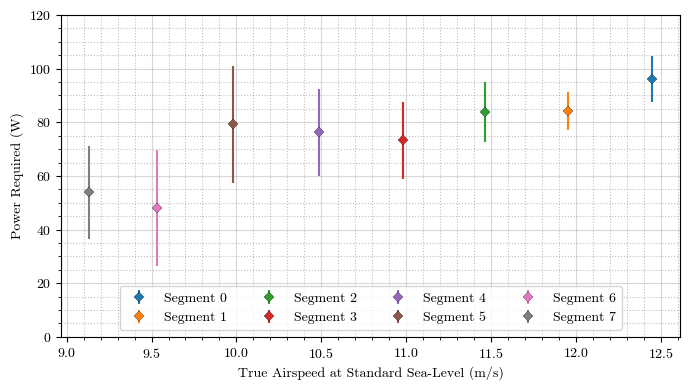

In [58]:
# Plot of Power Required Fits and Data #

[Pave_ct, EAS_Ct] = cl_finders.rawpolar2preqew(createv, cl_means_ct, cd_means_ct)
[Pave_eta, EAS_eta] = cl_finders.rawpolar2preqew(createv, cl_means_eta, cd_means_eta)
[Pave_cth, EAS_Cth] = cl_finders.rawpolar2preqew(createv, cl_means_cth, cd_means_cth)

CTPolar_SegmentedwBadData = plt.figure(figsize=(7,4), dpi=100)
for i in range(len(masks)):
    plt.errorbar(EAS_Ct[i], Pave_ct[i], yerr=cd_stds_ct[i]*0.5*1.225*createv.area*EAS_Ct[i]**3 , label="Segment "+str(i), linestyle='', marker='D', markersize=5)
# plt.errorbar(EAS_eta[i], Pave_eta[i], yerr=cd_stds_eta[i]*0.5*1.225*createv.area*EAS_eta[i]**3 , label="$\eta$ Raw", linestyle='', marker='o', markersize=5)
# plt.errorbar(EAS_Cth[i], Pave_cth[i], yerr=cd_stds_cth[i]*0.5*1.225*createv.area*EAS_Cth[i]**3 , label="$C_T$ $\dot{h}$ Raw", linestyle='', marker='x', markersize=5)

plt.xlabel("True Airspeed at Standard Sea-Level (m/s)")
plt.ylabel("Power Required (W)")
plt.ylim([0, 120])
plt.legend(loc='lower center', ncol=4)
plt.grid(which='major', linestyle='-')
plt.grid(which='minor', linestyle=':', color='grey')
plt.minorticks_on()
plt.tight_layout()
plt.show()
main.save_figure(CTPolar_SegmentedwBadData, f'{CTPolar_SegmentedwBadData=}'.split('=')[0], figure_path)

#### <a id='toc1_15_1_1_'></a>[Notes on Data Results](#toc0_)

From the running power require calculations, it appear that segments 4 and 5 are not settled.  This is likely due to an extended thermal that the vehicle flew over.  These data-points should be removed from results, since they are clearly not indicative of the vehicle being in a settled state.  

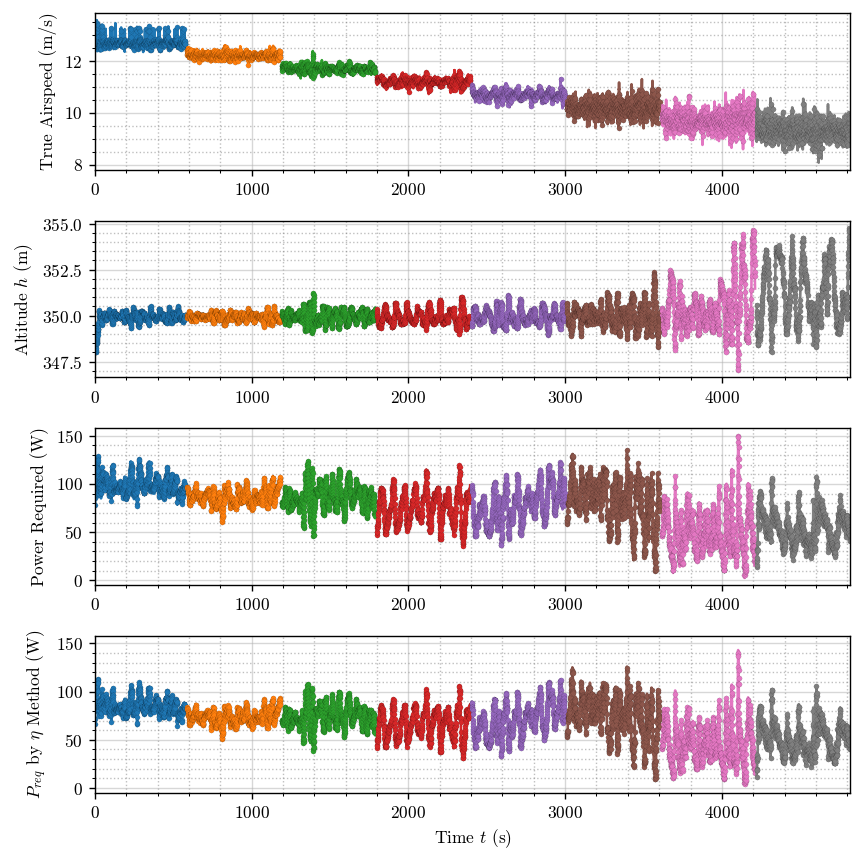

In [59]:
# Plotting Steady-level Data Runs #
markerstyle = 'o'
markerevery = 80
markedgew = 0.05
timeindex_v_h_P = plt.figure(figsize=(7,7), dpi=125)
ax1 = plt.subplot(4,1,1)
t_init = 0
for i in range(len(masks)):
    time_s = np.linspace(t_init, (len(v_tas[masks[i]])-1)/100 + t_init, len(v_tas[masks[i]]))
    ax1.plot(time_s, v_tas[masks[i]], marker=markerstyle, markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew)
    t_init = time_s[-1]+10
ax1.set_ylabel("True Airspeed (m/s)")
ax1.grid(which='major', linestyle='-')
ax1.grid(which='minor', linestyle=':', color='grey')
ax1.autoscale(enable=True, axis='x', tight=True)

ax0 = plt.subplot(4,1,2, sharex=ax1)
t_init = 0
for i in range(len(masks)):
    time_s = np.linspace(t_init, (len(v_tas[masks[i]])-1)/100 + t_init, len(v_tas[masks[i]]))
    ax0.plot(time_s, h[masks[i]], marker=markerstyle, markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew)
    t_init = time_s[-1]+10
ax0.set_ylabel("Altitude $h$ (m)")
ax0.grid(which='major', linestyle='-')
ax0.grid(which='minor', linestyle=':', color='grey')
ax0.autoscale(enable=True, axis='x', tight=True)

ax2 = plt.subplot(4,1,3, sharex=ax1)
t_init = 0
for i in range(len(masks)):
    time_s = np.linspace(t_init, (len(v_tas[masks[i]])-1)/100 + t_init, len(v_tas[masks[i]]))
    ax2.plot(time_s, P_ct[masks[i]], marker=markerstyle, markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew)
    t_init = time_s[-1]+10
ax2.set_ylabel("Power Required (W)")
ax2.grid(which='major', linestyle='-')
ax2.grid(which='minor', linestyle=':', color='grey')
ax2.autoscale(enable=True, axis='x', tight=True)

ax3 = plt.subplot(4,1,4, sharex=ax1, sharey=ax2)
t_init = 0
for i in range(len(masks)):
    time_s = np.linspace(t_init, (len(v_tas[masks[i]])-1)/100 + t_init, len(v_tas[masks[i]]))
    ax3.plot(time_s, P_eta[masks[i]], marker=markerstyle, markeredgecolor=[0,0,0], markersize=3, markevery=markerevery, markeredgewidth=markedgew)
    t_init = time_s[-1]+10
ax3.set_ylabel("$P_{req}$ by $\eta$ Method (W)")
ax3.set_xlabel("Time $t$ (s)")
ax3.grid(which='major', linestyle='-')
ax3.grid(which='minor', linestyle=':', color='grey')
ax3.autoscale(enable=True, axis='x', tight=True)

plt.tight_layout()
plt.show()
main.save_figure(timeindex_v_h_P, f'{timeindex_v_h_P=}'.split('=')[0], figure_path)